1. Tải Dataset

In [48]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"huakhonghen","key":"398c355d6c43117f3fd665a764649844"}'}

In [49]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [50]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [51]:
import zipfile
import os

with zipfile.ZipFile("cifake-real-and-ai-generated-synthetic-images.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset_cifake") # Giải nén vào thư mục tên dataset_cifake

print("oke")

oke


In [52]:
!ls

 cifake-real-and-ai-generated-synthetic-images.zip  'kaggle (1).json'
 custom_cnn_cifake.pth				     kaggle.json
 dataset_cifake					     sample_data
 drive


In [53]:
!cd dataset_cifake/

In [54]:
!ls

 cifake-real-and-ai-generated-synthetic-images.zip  'kaggle (1).json'
 custom_cnn_cifake.pth				     kaggle.json
 dataset_cifake					     sample_data
 drive


In [55]:
!ls dataset_cifake/


test  train


2. Xây dựng lớp đọc dữ liệu

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


In [58]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [59]:
data_dir = 'dataset_cifake'

In [60]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(dataset_sizes["train"])
print(dataset_sizes["test"])
print(class_names)

100000
20000
['FAKE', 'REAL']


3. CNN

In [61]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
net = Net().to(device)

4. Loss function và optimizer

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

5. Huấn luyện

In [63]:
num_epochs=10

history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}/{num_epochs}')
  print('-' * 10)

  for phase in ['train', 'test']:
      if phase == 'train': net.train()
      else: net.eval()

      running_loss = 0.0
      corrects = 0

      for inputs, labels in dataloaders[phase]:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
              outputs = net(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              if phase == 'train':
                  loss.backward()
                  optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = corrects.double() / dataset_sizes[phase]

      # In kết quả ra màn hình
      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # GHI LẠI VÀO LỊCH SỬ ĐỂ VẼ BIỂU ĐỒ
      if phase == 'train':
          history['train_loss'].append(epoch_loss)
          # Cần chuyển tensor sang số thực (cpu().numpy()) để vẽ
          history['train_acc'].append(epoch_acc.cpu().numpy())
      else:
          history['test_loss'].append(epoch_loss)
          history['test_acc'].append(epoch_acc.cpu().numpy())



Epoch 1/10
----------
train Loss: 0.3851 Acc: 0.8332
test Loss: 0.3086 Acc: 0.8363
Epoch 2/10
----------
train Loss: 0.2594 Acc: 0.8972
test Loss: 0.2385 Acc: 0.9061
Epoch 3/10
----------
train Loss: 0.1995 Acc: 0.9257
test Loss: 0.1840 Acc: 0.9248
Epoch 4/10
----------
train Loss: 0.1680 Acc: 0.9365
test Loss: 0.1453 Acc: 0.9438
Epoch 5/10
----------
train Loss: 0.1482 Acc: 0.9438
test Loss: 0.1381 Acc: 0.9478
Epoch 6/10
----------
train Loss: 0.1364 Acc: 0.9484
test Loss: 0.1328 Acc: 0.9496
Epoch 7/10
----------
train Loss: 0.1230 Acc: 0.9534
test Loss: 0.1243 Acc: 0.9536
Epoch 8/10
----------
train Loss: 0.1119 Acc: 0.9584
test Loss: 0.1292 Acc: 0.9509
Epoch 9/10
----------
train Loss: 0.1019 Acc: 0.9617
test Loss: 0.1404 Acc: 0.9485
Epoch 10/10
----------
train Loss: 0.0957 Acc: 0.9637
test Loss: 0.1034 Acc: 0.9610


6. Lưu

1. Đã lưu mô hình thành công vào: custom_cnn_cifake.pth

2. Đang vẽ biểu đồ huấn luyện...


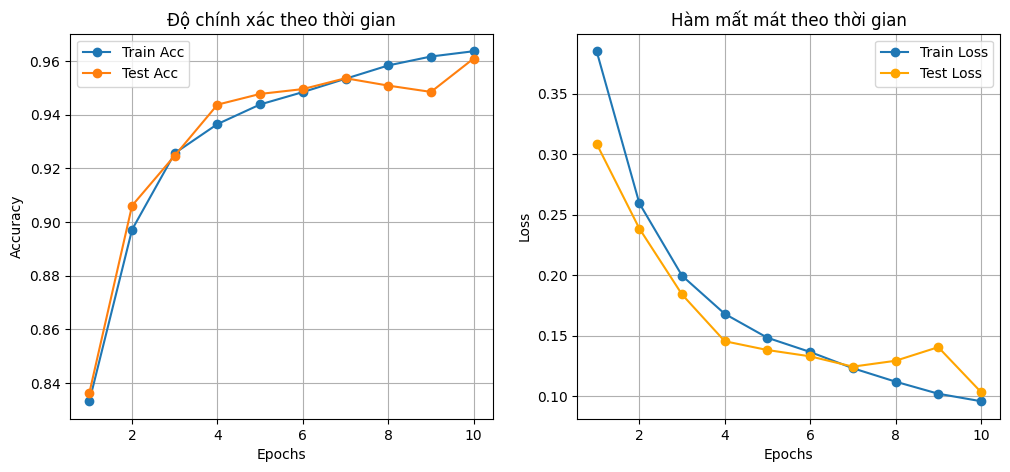

In [65]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

SAVE_PATH = 'custom_cnn_cifake.pth'
torch.save(net.state_dict(), SAVE_PATH)
print(f"1. Đã lưu mô hình thành công vào: {SAVE_PATH}")


print("\n2. Đang vẽ biểu đồ huấn luyện...")
epochs_range = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(12, 5)) # Tạo khung tranh kích thước 12x5

# Biểu đồ 1: Độ chính xác (Accuracy)
plt.subplot(1, 2, 1) # Hàng 1, Cột 2, Vị trí 1
plt.plot(epochs_range, history['train_acc'], label='Train Acc', marker='o')
plt.plot(epochs_range, history['test_acc'], label='Test Acc', marker='o')
plt.title('Độ chính xác theo thời gian')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Biểu đồ 2: Độ mất mát (Loss)
plt.subplot(1, 2, 2) # Hàng 1, Cột 2, Vị trí 2
plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs_range, history['test_loss'], label='Test Loss', marker='o', color='orange')
plt.title('Hàm mất mát theo thời gian')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

7. Test

In [69]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms

def test_random_10_images(model_path=SAVE_PATH):
    # 1. Load lại Model
    # Đảm bảo class Net() và biến device đã được định nghĩa ở các cell trước
    model_test = Net()
    if os.path.exists(model_path):
        model_test.load_state_dict(torch.load(model_path, map_location=device))
    else:
        print(f"Không tìm thấy file model: {model_path}")
        return

    model_test.to(device)
    model_test.eval()

    # 2. Định nghĩa Transform (giống hệt lúc train)
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 3. Lấy danh sách tất cả ảnh trong folder test
    test_dir = 'dataset_cifake/test'
    all_image_paths = []

    # Duyệt qua các thư mục con (REAL, FAKE) để lấy file
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(root, file))

    # Kiểm tra xem có đủ ảnh không
    num_images = 10
    if len(all_image_paths) < num_images:
        print(f"Chỉ tìm thấy {len(all_image_paths)} ảnh. Sẽ test tất cả.")
        selected_paths = all_image_paths
    else:
        # Chọn ngẫu nhiên 10 ảnh
        selected_paths = random.sample(all_image_paths, num_images)

    # 4. Dự đoán và Hiển thị
    plt.figure(figsize=(15, 7)) # Kích thước khung hình lớn để chứa 10 ảnh

    # Lấy tên class (thường là ['FAKE', 'REAL'] do sắp xếp alphabet)
    # Nếu biến image_datasets vẫn còn trong memory thì dùng, không thì hardcode
    try:
        class_names = image_datasets['train'].classes
    except NameError:
        class_names = ['FAKE', 'REAL']

    for i, image_path in enumerate(selected_paths):
        try:
            # Xử lý ảnh
            img = Image.open(image_path).convert('RGB')
            img_tensor = transform(img)
            img_batch = img_tensor.unsqueeze(0).to(device)

            # Dự đoán
            with torch.no_grad():
                outputs = model_test(img_batch)
                probabilities = F.softmax(outputs, dim=1)
                confidence, predicted_idx = torch.max(probabilities, 1)

            predicted_label = class_names[predicted_idx.item()]
            conf_score = confidence.item() * 100

            # Lấy nhãn thực tế từ đường dẫn (VD: .../test/REAL/img.jpg -> REAL)
            # Hệ điều hành khác nhau có thể dùng \\ hoặc /
            true_label = "FAKE" if "FAKE" in image_path.upper() else "REAL"

            # Tô màu tiêu đề: Xanh nếu đúng, Đỏ nếu sai
            title_color = 'green' if predicted_label == true_label else 'red'

            # Vẽ ảnh lên lưới
            plt.subplot(2, 5, i + 1) # 2 hàng, 5 cột, vị trí thứ i+1
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Pred: {predicted_label}\nTrue: {true_label}\nConf: {conf_score:.1f}%",
                      color=title_color, fontsize=10, fontweight='bold')

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {image_path}: {e}")

    plt.tight_layout()
    plt.show()

# Gọi hàm để chạy


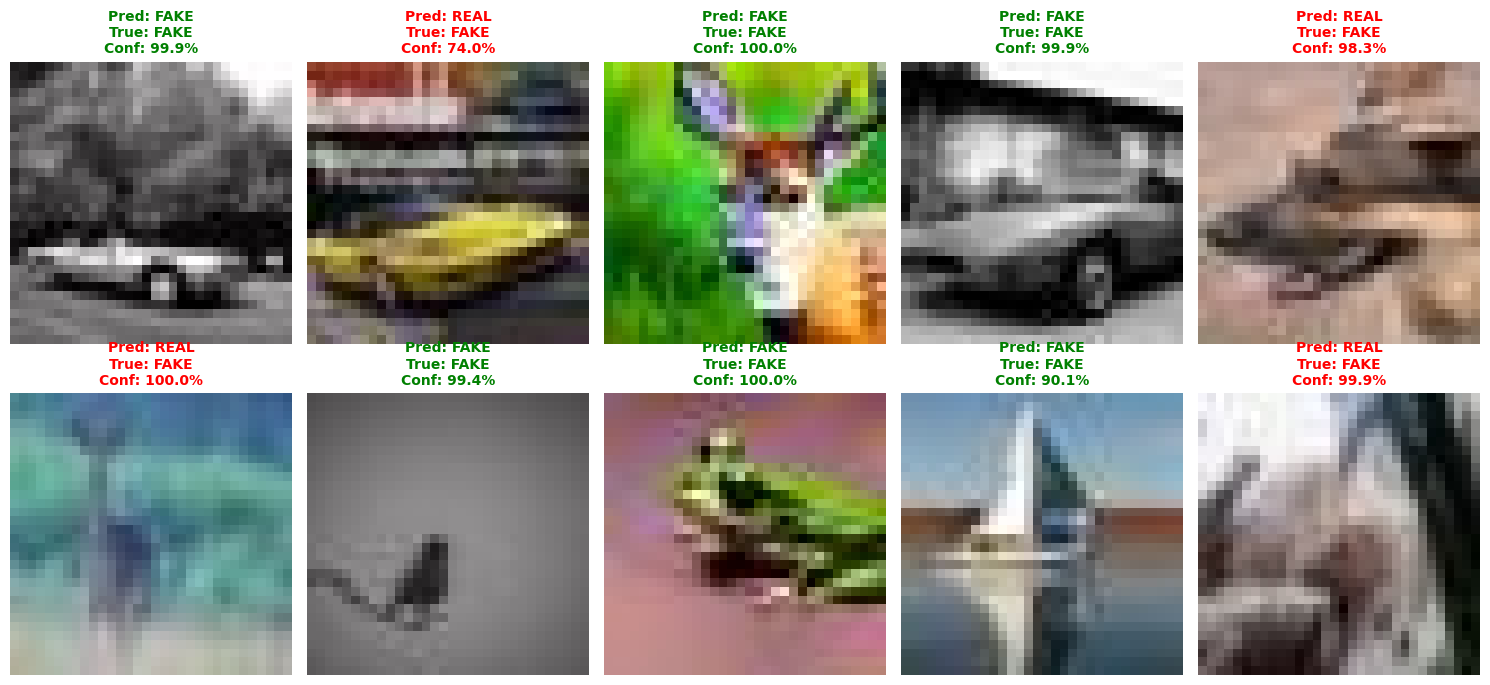

In [71]:
test_random_10_images()